<a href="https://colab.research.google.com/github/ChrisHarvey21/HABs/blob/main/HABs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#HABs Model
#creating a model to determine HAB severity based on input variables

In [2]:
%%capture
!pip install geopandas
!pip install libpysal

In [3]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from numpy import mean
from numpy import std
from numpy import absolute
from libpysal.weights.contiguity import Queen
import libpysal
from statsmodels.api import OLS
sns.set_style('white')

In [4]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
#Load in Dataset
#Data from NYSDEC website at url "https://nysdec.maps.arcgis.com/apps/webappviewer/index.html?id=692b72ae03f14508a0de97488e142ae1"
#Select HABs status
#Filter by your lake of interest.  Skaneateles Lake ID code is 0707SKA0193
#Click Options and export to CSV
#The link below imports the data from the described above downlaoded CSV.

url = 'https://raw.githubusercontent.com/ChrisHarvey21/HABs/main/Lakes_%20HABs%20Status.csv'

df1 = pd.read_csv(url)


In [75]:
#Obtain Precipitation and Temperature Data
#The site used for data gathering is "http://climod2.nrcc.cornell.edu/"
#Next proceed to the heading Product seleciton and choose single station and Daily Data Listing
#Click on the tab Options Selections and choose HTML, the range of dates, and the parameters you want.
#For this script I chose HTML, 2016-11-01 to 2022-11-03, max temp, min temp, average temp, and precipitation
#I selected Syracuse Hancock Airport
#Click Go
#To download the data I copy and pasted the data into an excel csv file.  I then uploaded it to github

url2 = 'https://raw.githubusercontent.com/ChrisHarvey21/HABs/main/precip.csv'

df2 = pd.read_csv(url2)

df2.head()

,Date,Max_Temp,Min_Temp,Avg_Temp,Precip
0,11/1/2016,60,28,44,0
1,11/2/2016,61,45,53,0.19
2,11/3/2016,56,47,51.5,0.65
3,11/4/2016,49,37,43,0.02
4,11/5/2016,58,44,51,0


In [76]:
#Remove dates with no HABs
df1 = df1.dropna(subset=['HS_HAB_STATUS_DATE'])
df1.head()

,LAKE_ID,LOCATION_ID,LOCATION_TYPE,SAMPLE_TIME,DATA_PROVIDER,HS_HAB_STATUS,HS_HAB_STATUS_DATE,HFD_EXTENT,INFORMATION_TYPE
28,0707SKA0193,0707SKA0193_3502,SHORE,"9/15/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"10/4/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample
29,0707SKA0193,0707SKA0193_3502,SHORE,"9/15/2018, 8:00 PM",SKA,CONFIRMED,"9/18/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample
51,0707SKA0193,0707SKA0193_3502,SHORE,"9/9/2020, 3:48 PM",SKA,CONFIRMED,"9/8/2020, 8:00 PM",SMALL LOCALIZED,HAB_Report
54,0707SKA0193,0707SKA0193_3502,SHORE,"9/25/2020, 2:46 PM",SKA,CONFIRMED,"9/24/2020, 8:00 PM",LARGE LOCALIZED,HAB_Report
85,0707SKA0193,0707SKA0193_3504,SHORE,"8/10/2018, 8:00 PM",SKA,NO BLOOM,"8/13/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample


In [78]:
#Split Data and Time in df1 so we can combine datasets based on time
df1['Date'] = pd.to_datetime(df1['HS_HAB_STATUS_DATE']).dt.date
df1['Time'] = pd.to_datetime(df1['HS_HAB_STATUS_DATE']).dt.time

In [79]:
#clean data
df1['Date'] = pd.to_datetime(df1.Date)
df1.info()

#Check for duplicates
df1.nunique()

#remove duplicates
df1.drop_duplicates(subset=['Date'], keep=False, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 28 to 712
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   LAKE_ID             100 non-null    object        
 1   LOCATION_ID         100 non-null    object        
 2   LOCATION_TYPE       100 non-null    object        
 3   SAMPLE_TIME         100 non-null    object        
 4   DATA_PROVIDER       100 non-null    object        
 5   HS_HAB_STATUS       100 non-null    object        
 6   HS_HAB_STATUS_DATE  100 non-null    object        
 7   HFD_EXTENT          100 non-null    object        
 8   INFORMATION_TYPE    100 non-null    object        
 9   Date                100 non-null    datetime64[ns]
 10  Time                100 non-null    object        
dtypes: datetime64[ns](1), object(10)
memory usage: 9.4+ KB


In [82]:
#dataframe one reset index
df1 = pd.DataFrame(df1)
df1.reset_index()

,index,LAKE_ID,LOCATION_ID,LOCATION_TYPE,SAMPLE_TIME,DATA_PROVIDER,HS_HAB_STATUS,HS_HAB_STATUS_DATE,HFD_EXTENT,INFORMATION_TYPE,Date,Time
0,28,0707SKA0193,0707SKA0193_3502,SHORE,"9/15/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"10/4/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-10-04,20:00:00
1,29,0707SKA0193,0707SKA0193_3502,SHORE,"9/15/2018, 8:00 PM",SKA,CONFIRMED,"9/18/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-09-18,20:00:00
2,51,0707SKA0193,0707SKA0193_3502,SHORE,"9/9/2020, 3:48 PM",SKA,CONFIRMED,"9/8/2020, 8:00 PM",SMALL LOCALIZED,HAB_Report,2020-09-08,20:00:00
3,351,0707SKA0193,0707SKA0193_3524,SHORE,"8/6/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"8/16/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-08-16,20:00:00
4,352,0707SKA0193,0707SKA0193_3524,SHORE,"8/6/2018, 8:00 PM",SKA,CONFIRMED,"8/8/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-08-08,20:00:00
5,353,0707SKA0193,0707SKA0193_3524,SHORE,"9/3/2018, 8:00 PM",SKA,CONFIRMED,"9/4/2018, 8:00 PM",SMALL LOCALIZED,ShoreBloom_Sample,2018-09-04,20:00:00
6,354,0707SKA0193,0707SKA0193_3524,SHORE,"9/3/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"9/6/2018, 8:00 PM",SMALL LOCALIZED,ShoreBloom_Sample,2018-09-06,20:00:00
7,356,0707SKA0193,0707SKA0193_3524,SHORE,"9/26/2018, 8:00 PM",SKA,CONFIRMED,"9/27/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-09-27,20:00:00
8,358,0707SKA0193,0707SKA0193_3524,SHORE,"10/7/2018, 8:00 PM",SKA,CONFIRMED,"10/8/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-10-08,20:00:00
9,372,0707SKA0193,0707SKA0193_3524,SHORE,"9/8/2019, 8:00 PM",SKA,SUSPICIOUS,"9/8/2019, 8:00 PM",SMALL LOCALIZED,HAB_Report,2019-09-08,20:00:00


In [83]:
#change the date type of data set 2 so both can be merged together
df2['Date'] = pd.to_datetime(df2.Date)
df2 = pd.DataFrame(df2)
df2.reset_index

<bound method DataFrame.reset_index of            Date Max_Temp Min_Temp Avg_Temp Precip
0    2016-11-01       60       28       44      0
1    2016-11-02       61       45       53   0.19
2    2016-11-03       56       47     51.5   0.65
3    2016-11-04       49       37       43   0.02
4    2016-11-05       58       44       51      0
...         ...      ...      ...      ...    ...
2189 2022-10-30       68       30       49      0
2190 2022-10-31       64       39     51.5      T
2191 2022-11-01       67       49       58      T
2192 2022-11-02       65       45       55      0
2193 2022-11-03        M        M        M      M

[2194 rows x 5 columns]>

In [93]:
#merge data sets together
merge = pd.merge(df1, df2, how='outer', on = 'Date')

In [96]:
#add new column for 1 day before precip
merge['Precip1'] = np.nan
merge['Precip2'] = np.nan
merge['PrecipSum'] = np.nan
merge['severity'] = np.nan
merge.head()

,LAKE_ID,LOCATION_ID,LOCATION_TYPE,SAMPLE_TIME,DATA_PROVIDER,HS_HAB_STATUS,HS_HAB_STATUS_DATE,HFD_EXTENT,INFORMATION_TYPE,Date,Time,Max_Temp,Min_Temp,Avg_Temp,Precip,Precip1,Precip2,PrecipSum,severity
0,0707SKA0193,0707SKA0193_3502,SHORE,"9/15/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"10/4/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-10-04,20:00:00,71,51,61,0.1,NaN,NaN,NaN,NaN
1,0707SKA0193,0707SKA0193_3502,SHORE,"9/15/2018, 8:00 PM",SKA,CONFIRMED,"9/18/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-09-18,20:00:00,81,64,72.5,0.07,NaN,NaN,NaN,NaN
2,0707SKA0193,0707SKA0193_3502,SHORE,"9/9/2020, 3:48 PM",SKA,CONFIRMED,"9/8/2020, 8:00 PM",SMALL LOCALIZED,HAB_Report,2020-09-08,20:00:00,86,64,75,0,NaN,NaN,NaN,NaN
3,0707SKA0193,0707SKA0193_3524,SHORE,"8/6/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"8/16/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-08-16,20:00:00,86,70,78,T,NaN,NaN,NaN,NaN
4,0707SKA0193,0707SKA0193_3524,SHORE,"8/6/2018, 8:00 PM",SKA,CONFIRMED,"8/8/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-08-08,20:00:00,81,65,73,0.67,NaN,NaN,NaN,NaN


In [100]:
#Create new column with algal severity
merge.loc[merge['HS_HAB_STATUS'] == 'NO BLOOM', 'severity'] = '0'  
merge.loc[merge['HS_HAB_STATUS'] == 'CONFIRMED WITH HIGH TOXINS', 'severity'] = '3'  
merge.loc[merge['HS_HAB_STATUS'] == 'CONFIRMED', 'severity'] = '2'  
merge.loc[merge['HS_HAB_STATUS'] == 'SUSPICIOUS', 'severity'] = '1'  

,LAKE_ID,LOCATION_ID,LOCATION_TYPE,SAMPLE_TIME,DATA_PROVIDER,HS_HAB_STATUS,HS_HAB_STATUS_DATE,HFD_EXTENT,INFORMATION_TYPE,Date,Time,Max_Temp,Min_Temp,Avg_Temp,Precip,Precip1,Precip2,PrecipSum,severity
0,0707SKA0193,0707SKA0193_3502,SHORE,"9/15/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"10/4/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-10-04,20:00:00,71,51,61,0.1,NaN,NaN,NaN,3
1,0707SKA0193,0707SKA0193_3502,SHORE,"9/15/2018, 8:00 PM",SKA,CONFIRMED,"9/18/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-09-18,20:00:00,81,64,72.5,0.07,NaN,NaN,NaN,2
2,0707SKA0193,0707SKA0193_3502,SHORE,"9/9/2020, 3:48 PM",SKA,CONFIRMED,"9/8/2020, 8:00 PM",SMALL LOCALIZED,HAB_Report,2020-09-08,20:00:00,86,64,75,0,NaN,NaN,NaN,2
3,0707SKA0193,0707SKA0193_3524,SHORE,"8/6/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"8/16/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-08-16,20:00:00,86,70,78,T,NaN,NaN,NaN,3
4,0707SKA0193,0707SKA0193_3524,SHORE,"8/6/2018, 8:00 PM",SKA,CONFIRMED,"8/8/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-08-08,20:00:00,81,65,73,0.67,NaN,NaN,NaN,2
5,0707SKA0193,0707SKA0193_3524,SHORE,"9/3/2018, 8:00 PM",SKA,CONFIRMED,"9/4/2018, 8:00 PM",SMALL LOCALIZED,ShoreBloom_Sample,2018-09-04,20:00:00,85,69,77,0,NaN,NaN,NaN,2
6,0707SKA0193,0707SKA0193_3524,SHORE,"9/3/2018, 8:00 PM",SKA,CONFIRMED WITH HIGH TOXINS,"9/6/2018, 8:00 PM",SMALL LOCALIZED,ShoreBloom_Sample,2018-09-06,20:00:00,80,66,73,0,NaN,NaN,NaN,3
7,0707SKA0193,0707SKA0193_3524,SHORE,"9/26/2018, 8:00 PM",SKA,CONFIRMED,"9/27/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-09-27,20:00:00,62,47,54.5,T,NaN,NaN,NaN,2
8,0707SKA0193,0707SKA0193_3524,SHORE,"10/7/2018, 8:00 PM",SKA,CONFIRMED,"10/8/2018, 8:00 PM",NOT REPORTED,ShoreBloom_Sample,2018-10-08,20:00:00,75,54,64.5,0,NaN,NaN,NaN,2
9,0707SKA0193,0707SKA0193_3524,SHORE,"9/8/2019, 8:00 PM",SKA,SUSPICIOUS,"9/8/2019, 8:00 PM",SMALL LOCALIZED,HAB_Report,2019-09-08,20:00:00,70,54,62,0,NaN,NaN,NaN,1


In [67]:
df2.head()

,Date,Max_Temp,Min_Temp,Avg_Temp,Precip
0,11/1/2016,60,28,44,0
1,11/2/2016,61,45,53,0.19
2,11/3/2016,56,47,51.5,0.65
3,11/4/2016,49,37,43,0.02
4,11/5/2016,58,44,51,0


In [ ]:
#Create subset of habs called mylist
my_list = ["date", "severity", "precip", "precip_1_day" , "pecip_2_day", "3_day_sum", "max_temp", "mean_temp"]      

In [ ]:
#check to make sure all your columns are there:
df1[my_list].head(10)

,date,severity,precip,precip_1_day,pecip_2_day,3_day_sum,max_temp,mean_temp
0,9/15/2017,3,0.00,NaN,NaN,0.00,80,68
1,9/16/2017,0,NaN,0.00,NaN,0.00,82,68
2,9/17/2017,0,0.00,NaN,0.00,0.00,84,68
3,9/18/2017,0,0.00,0.00,NaN,0.00,86,71
4,9/19/2017,0,0.00,0.00,0.00,0.00,80,70
5,9/20/2017,0,0.00,0.00,0.00,0.00,82,68
6,9/21/2017,0,0.01,0.00,0.00,0.01,82,69
7,9/22/2017,0,0.02,0.01,0.00,0.03,82,66
8,9/23/2017,0,0.00,0.02,0.01,0.03,85,68
9,9/24/2017,2,0.00,0.00,0.02,0.02,89,73


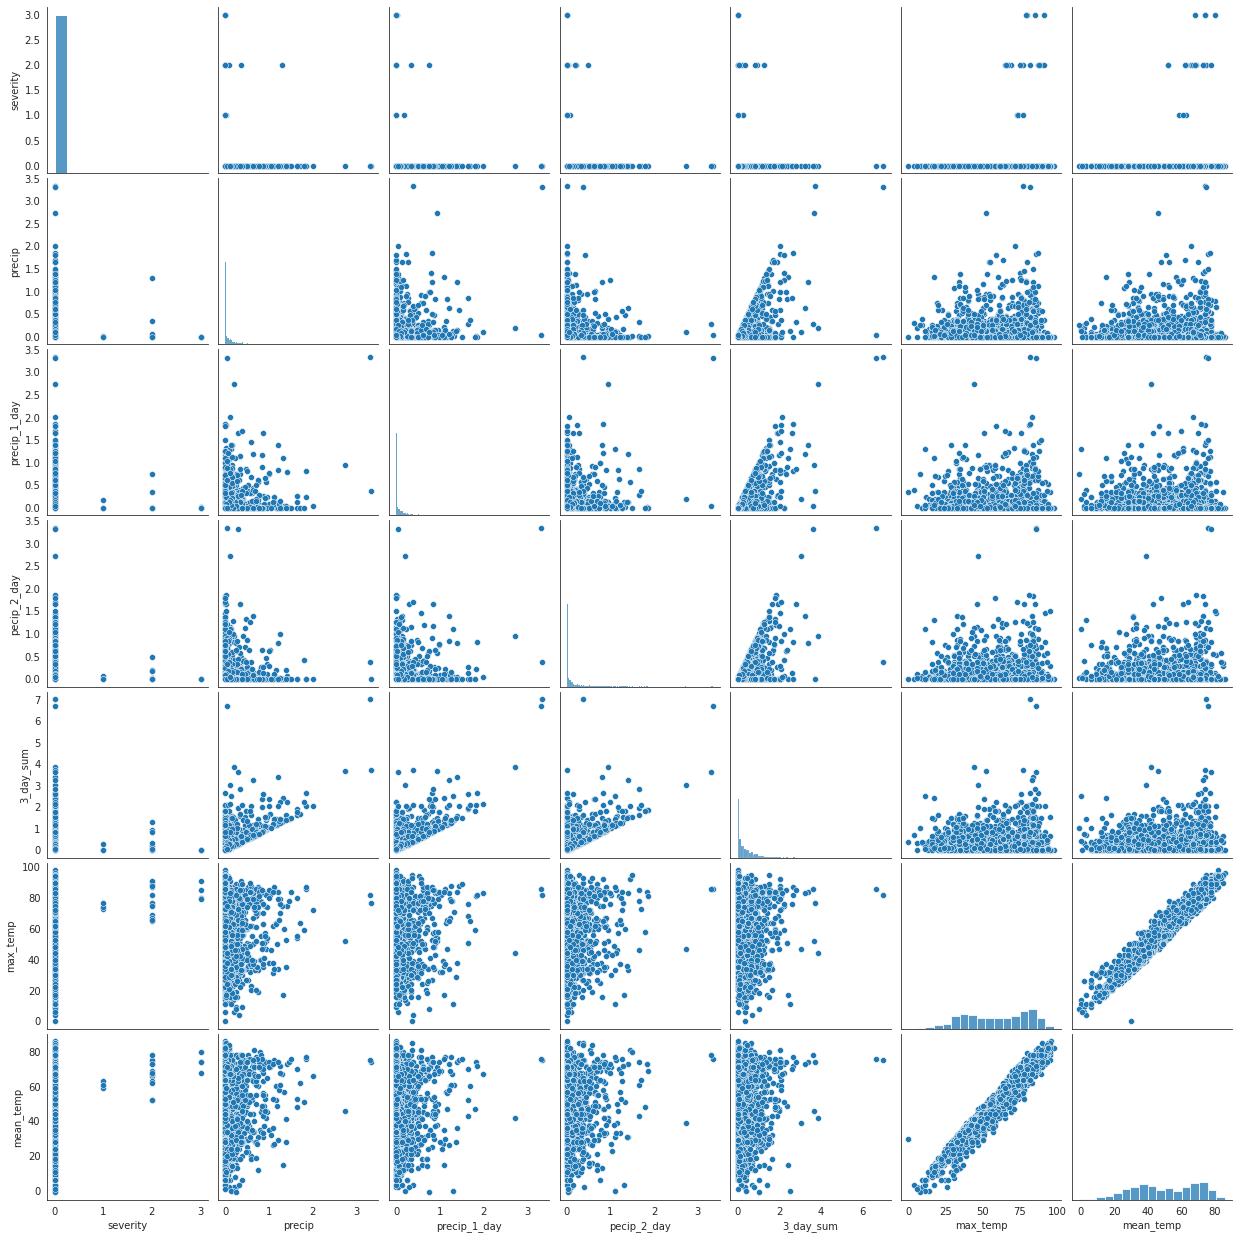

In [ ]:
#Seaborn.pairplot to plot a scatterplot matrix
sns.pairplot(df1[my_list])

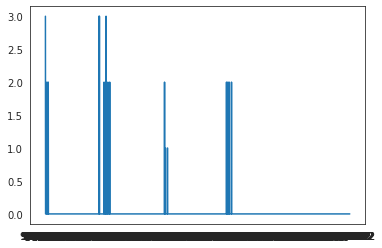

In [ ]:
#look at timeseries of algal seveirty versus time of year
plt.plot(df1['date'],df1['severity'])
plt.show()

In [ ]:
#Do VIF, if any are greater than 10 we have to either throw out predictor variables that arent important or add on bias reducers
#Calculate VIFs on our dataset
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df1[my_list[1:11]].values, i) for i in range(df1[my_list[1:11]].shape[1])]
vif["features"] = df1[my_list[1:11]].columns

MissingDataError: ignored

In [ ]:
vif.round()